In [1]:
import pandas as pd
import os
import os.path as osp
from glob import glob
import sys
from const import ID2LABELS_SMG as LABEL2ID
# Add the parent directory to the Python path
sys.path.insert(0, '..')
import numpy as np
import torch

In [2]:
path_to_root_folder = '\Project-mpg microgesture\smg\smg_split_files'
path_to_root_folder = osp.join(*path_to_root_folder.split('/'))

train_data_path = osp.join(path_to_root_folder,'train.csv')
val_data_path = osp.join(path_to_root_folder,'validation.csv')

train_files_folder = osp.join(path_to_root_folder, 'train')
val_files_folder = osp.join(path_to_root_folder, 'validation')

In [5]:
df_train_raw = pd.read_csv(train_data_path, index_col=0)
df_val_raw = pd.read_csv(val_data_path, index_col=0)

In [6]:
df_train_raw.head()

,label,start_frame,end_frame,paths,basename,durations
0,15,100,176,..\..\smg\smg_split_files\train\Sample0001_col...,Sample0001,76
1,12,837,889,..\..\smg\smg_split_files\train\Sample0001_col...,Sample0001,52
2,12,1710,1749,..\..\smg\smg_split_files\train\Sample0001_col...,Sample0001,39
3,8,4849,4885,..\..\smg\smg_split_files\train\Sample0001_col...,Sample0001,36
4,9,6330,6368,..\..\smg\smg_split_files\train\Sample0001_col...,Sample0001,38


In [7]:
df_train_raw.columns

Index(['label', 'start_frame', 'end_frame', 'paths', 'basename', 'durations'], dtype='object')

In [8]:
# # Structure of the final dataset: filename, labels
# def get_video_list(files_folder):
#     all_files = glob(osp.join(files_folder, '*.mp4'))
#     base_names = [osp.basename(f) for f in all_files]
#     sample_id = [int(osp.splitext(f)[0].split('-')[0]) for f in base_names]
#     view = [(osp.splitext(f)[0].split('-video')[-1]) for f in base_names]
#     df = pd.DataFrame(zip(all_files, base_names, sample_id, view), columns=['filenames', 'base_name', 'sample_id', 'view'])
#     return df
# df_train_files = get_video_list(files_folder=train_files_folder)
# df_val_files = get_video_list(files_folder=val_files_folder)
# # file_sample_ids.sort()
# # file_sample_ids
# # df_train_files

In [9]:
def convert_df(df_in):
        
    df_out = pd.DataFrame()
    
    df_out['filenames'] = df_in['paths'].apply(lambda x: osp.basename(x))
    df_out['folder_name'] = df_in['paths'].apply(lambda x: x.split('\\')[-2])
    df_out['durations'] = df_in['durations']
    
    df_out['view'] = 'center'
    metadata = pd.DataFrame()
    
    
    metadata['sample_id'] = df_out['filenames'].apply(lambda x: x.split('.')[0].replace('Sample','').replace('color_',''))
    metadata['start_frame'] = df_in['start_frame']
    metadata['end_frame'] = df_in['end_frame']
    metadata['label_txt'] = df_in['label'].apply(lambda x: LABEL2ID[x])
    metadata['label']= df_in['label']
    metadata['view'] =  df_out['view']
    metadata['filenames'] = df_out['filenames']
    metadata['durations'] = df_out['durations']
    
    
    one_hot_encoded  = pd.get_dummies(df_in['label'], columns=LABEL2ID.keys())
    new_columns = one_hot_encoded.columns.to_list()
    one_hot_encoded = one_hot_encoded.astype(float)
    # df_out['labels'] = one_hot_encoded.values.tolist()
    df_out['labels'] = df_in['label'] - 1
    df_out['metadata'] = metadata.to_dict(orient='records')
    
    return df_out, new_columns, one_hot_encoded

df_train,new_columns, train_one_hot_encoded = convert_df(df_train_raw)
df_val, _, val_one_hot_encoded = convert_df(df_val_raw)

In [10]:
df_train

,filenames,folder_name,durations,view,labels,metadata
0,Sample0001_color_0001.mp4,train,76,center,14,"{'sample_id': '0001_0001', 'start_frame': 100,..."
1,Sample0001_color_0002.mp4,train,52,center,11,"{'sample_id': '0001_0002', 'start_frame': 837,..."
2,Sample0001_color_0003.mp4,train,39,center,11,"{'sample_id': '0001_0003', 'start_frame': 1710..."
3,Sample0001_color_0004.mp4,train,36,center,7,"{'sample_id': '0001_0004', 'start_frame': 4849..."
4,Sample0001_color_0005.mp4,train,38,center,8,"{'sample_id': '0001_0005', 'start_frame': 6330..."
...,...,...,...,...,...,...
51,Sample0030_color_0052.mp4,train,88,center,8,"{'sample_id': '0030_0052', 'start_frame': 1919..."
52,Sample0030_color_0053.mp4,train,97,center,8,"{'sample_id': '0030_0053', 'start_frame': 1941..."
53,Sample0030_color_0054.mp4,train,125,center,8,"{'sample_id': '0030_0054', 'start_frame': 1955..."
54,Sample0030_color_0055.mp4,train,66,center,8,"{'sample_id': '0030_0055', 'start_frame': 1968..."


array([[<Axes: title={'center': 'labels'}>]], dtype=object)

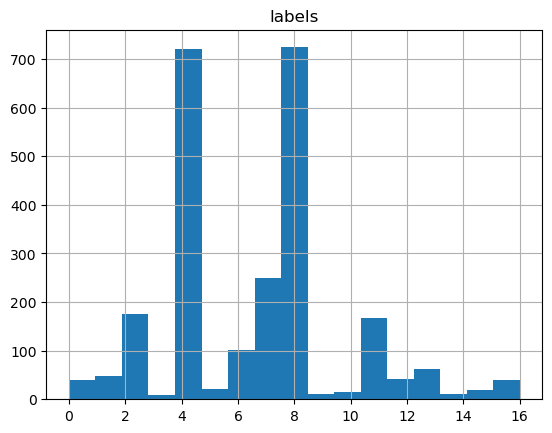

In [11]:
df_train.hist('labels', bins=17)

In [11]:
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_resample'

os.makedirs(osp.join(experiment_folder, run_name), exist_ok=True)
os.makedirs(osp.join(experiment_folder, run_name,'dataset'), exist_ok=True)

df_val.to_csv(osp.join(experiment_folder,'val.csv'))
df_train.to_csv(osp.join(experiment_folder,'train.csv'))


In [12]:
from torch.utils.data import DataLoader
import dyadic_communication
from importlib import reload
import debug_model
import run_videomae_vis_v2

reload(dyadic_communication)
reload(debug_model)
reload(run_videomae_vis_v2)

from argparse import Namespace
import mpigroup.const as const


D:\Project-mpg microgesture\human_micro_gesture_classifier\miga\..\modeling_finetune.py:306: UserWarning: Overwriting vit_small_patch16_224 in registry with modeling_finetune.vit_small_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_small_patch16_224(pretrained=False, **kwargs):
D:\Project-mpg microgesture\human_micro_gesture_classifier\miga\..\modeling_finetune.py:315: UserWarning: Overwriting vit_base_patch16_224 in registry with modeling_finetune.vit_base_patch16_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def vit_base_patch16_224(pretrained=False, **kwargs):
D:\Project-mpg microgesture\human_micro_gesture_classifier\miga\..\modeling_finetune.py:324: UserWarning: Overwriting vit_base_patch16_384 in registry with modeling_finetune.vit_base_patch16_384. This is because the name being registered conflicts with an existing na

In [13]:
reload(const)
cropping_map = const.cropping_map
cropping_map

{'front1': 'tr', 'front2': 'tl', 'right': 'bl', 'left': 'br', 'center': 'mm'}

In [14]:
data_path= r'D:\Project-mpg microgesture\smg\smg_split_files'

args = debug_model.args
args.anno_path = osp.join(experiment_folder,'val.csv')
args.data_path = data_path
args.data_root = data_path
args.mode = 'validation'
args.test_mode = False
dataset = dyadic_communication.DyadicvideoClsDataset(
          anno_path=args.anno_path,
            data_path=args.data_path,
            mode=args.mode,
            clip_len=1,
            num_segment=args.num_frames,
            test_num_segment=args.test_num_segment,
            test_num_crop=args.test_num_crop,
            num_crop=1 if not args.test_mode else 3,
            keep_aspect_ratio=True,
            crop_size=args.input_size,
            short_side_size=args.short_side_size,
            new_height=224,
            new_width=224,
            view_crop_mapping=cropping_map,
            corner_crop_size=None,
            data_root=args.data_root,
            args=args)



FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Project-mpg microgesture\\human_micro_gesture_classifier\\scripts\\miga_smg\\val.csv'

In [15]:

data = DataLoader(dataset=dataset, batch_size=5, shuffle=True)
iterdata = iter(data)

In [16]:
d = next(iterdata)
print(d[0].shape)
print(d[1])
print(d[2:])

torch.Size([5, 3, 16, 224, 224])
tensor([6, 6, 6, 6, 2])
[('D:\\Project-mpg microgesture\\smg\\smg_split_files\\validation\\Sample0033_color_0082', 'D:\\Project-mpg microgesture\\smg\\smg_split_files\\validation\\Sample0031_color_0044', 'D:\\Project-mpg microgesture\\smg\\smg_split_files\\validation\\Sample0033_color_0159', 'D:\\Project-mpg microgesture\\smg\\smg_split_files\\validation\\Sample0033_color_0005', 'D:\\Project-mpg microgesture\\smg\\smg_split_files\\validation\\Sample0033_color_0113'), {'sample_id': ['0033_0082', '0031_0044', '0033_0159', '0033_0005', '0033_0113'], 'start_frame': tensor([ 6978, 11895, 12230,   766,  8978]), 'end_frame': tensor([ 7023, 12078, 12316,   776,  9020]), 'label_txt': ['Arms akimbo', 'Arms akimbo', 'Arms akimbo', 'Arms akimbo', 'Moving legs'], 'view': ['center', 'center', 'center', 'center', 'center'], 'filenames': ['Sample0033_color_0082.mp4', 'Sample0031_color_0044.mp4', 'Sample0033_color_0159.mp4', 'Sample0033_color_0005.mp4', 'Sample0033_colo

In [17]:
reload(run_videomae_vis_v2)

vids = d[0]
labels = d[1]
label_txt = d[3]['label_txt']
fnames = d[3]['filenames']

for vid,label, txt_label, fname in zip(vids,labels, label_txt, fnames):
       
    # ret = get_activities(feature_names, label)

    txt =  '\n'.join([fname ,txt_label])
    
    vid = run_videomae_vis_v2.unnormalize_frames(vid)
    run_videomae_vis_v2.save_video(vid, osp.join('testing_'+fname), txt=txt)
    


In [18]:
# video_path = osp.join(path_to_root_folder,'clips_val','05942-video1.mp4')
# video_path

In [19]:
model_dict = {
    'experiment':'MPIG_densepose_dual_2',
    'description':'MPIG_densepose_dual - videoMAE-K400 , same as K400 but then was finetuned on MPIGroupInteractions dataset (train set) for 100 epochs, with denspose as additional decoding target',
    'checkpoint_path':r'D:\Project-mpg microgesture\pretrained\pretrained\MPIIGroupInteraction\k400_finetune_videomae_pretrain_dual_2_patch16_224_frame_16x4_tube_mask_ratio_0.9_e100\checkpoint-99.pth',
    'model_name':'pretrain_videomae_base_patch16_224_densepose_dual',
}

In [20]:
image_batch = d[0]
save_folder = osp.join('videos')
model_path = model_dict['checkpoint_path']
model_name = model_dict['model_name']

args = Namespace(
        image_batch=image_batch,
        save_path=save_folder, # list
        model_path=model_path, 
        mask_type='tube',
        num_frames=16,
        sampling_rate=4,
        decoder_depth=4,
        input_size=224,
        device='cuda:0',
        imagenet_default_mean_and_std=True,
        mask_ratio=0,
        model=model_name,
        densepose=True,
        drop_path=0.0)



In [21]:
model = run_videomae_vis_v2.get_model(args=args) 

checkpoint = torch.load(args.model_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()

# outputs = model(image_batch)   

Creating model: pretrain_videomae_base_patch16_224_densepose_dual


PretrainVisionTransformerMultiOutout(
  (encoder): PretrainVisionTransformerEncoder(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(3, 768, kernel_size=(2, 16, 16), stride=(2, 16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): Laye

In [22]:
outputs = model(image_batch) 

In [23]:
reload(run_videomae_vis_v2)



rec_videos_patches = outputs[0]
rec_densepose_patches = outputs[1]
patch_size = model.encoder.patch_embed.patch_size
unnorm_videos = run_videomae_vis_v2.unnormalize_frames(img=image_batch)
_, rec_videos, _ = run_videomae_vis_v2.reconstruct_video_from_patches(
    ori_img=unnorm_videos, patch_size=patch_size, bool_masked_pos=None, outputs=rec_videos_patches, frame_id_list=None)

_, rec_densepose, _ = run_videomae_vis_v2.reconstruct_video_from_patches(
    ori_img=unnorm_videos, patch_size=patch_size, bool_masked_pos=None, 
    outputs=rec_densepose_patches, frame_id_list=None,normalize_with_orig=False)

In [24]:
rec_densepose[0].shape

torch.Size([3, 16, 224, 224])

In [25]:
# a = (torch.nn.functional.normalize(rec_densepose[0],dim=0) + torch.Tensor([1,1,1])[:,None,None,None]) / torch.Tensor([2,2,2])[:,None,None,None]


In [26]:
# print(f'mean: {a.mean(dim=[1,2,3])}')
# print(f'std: {a.std(dim=[1,2,3])}')
# print(f'min: {a.reshape(3, -1).min(dim=1)[0]}')
# print(f'max: {a.reshape(3, -1).max(dim=1)[0] }')

In [27]:
print(f'mean: {rec_densepose[0].mean(dim=[1,2,3])}')
print(f'std: {rec_densepose[0].std(dim=[1,2,3])}')
print(f'min: {rec_densepose[0].reshape(3, -1).min(dim=1)[0]}')
print(f'max: {rec_densepose[0].reshape(3, -1).max(dim=1)[0] }')

mean: tensor([-1.6935e-05, -6.8499e-05,  3.8860e-05], grad_fn=<MeanBackward1>)
std: tensor([0.1546, 0.1683, 0.1660], grad_fn=<StdBackward0>)
min: tensor([-2.4869, -2.4794, -1.7007], grad_fn=<MinBackward0>)
max: tensor([7.5820, 7.5551, 5.9062], grad_fn=<MaxBackward0>)


In [28]:
import os

vids = d[0]
labels = d[1]
label_txt = d[3]['label_txt']
fnames = d[3]['filenames']

softmax = torch.nn.Softmax(dim=0)

for ori_vid,rec_vid,rec_dense,labels,txt_label, fname in zip(vids,rec_videos,rec_densepose,labels, label_txt, fnames):
       
    txt =  '\n'.join([fname ,txt_label])

    ori_vid = run_videomae_vis_v2.unnormalize_frames(ori_vid)
    rec_dense = run_videomae_vis_v2.unnormalize_frames(rec_dense)
    # rec_dense = (torch.nn.functional.normalize(rec_dense,dim=0) + torch.Tensor([1,1,1])[:,None,None,None]) / torch.Tensor([2,2,2])[:,None,None,None]
    # rec_vid = run_videomae_vis_v2.unnormalize_frames(rec_vid)
    # rec_dense = softmax(rec_dense)

    save_folder = osp.join('videos',fname.replace('.mp4',''))
    os.makedirs(save_folder, exist_ok=True)
    
    run_videomae_vis_v2.save_video(ori_vid, osp.join(save_folder,'ori_vid_'+fname), txt=txt)

    # run_videomae_vis_v2.save_video(ori_dense, osp.join(save_folder,'ori_dense_'+fname), txt=txt)

    run_videomae_vis_v2.save_video(rec_vid, osp.join(save_folder,'rec_vid_'+fname), txt=txt)

    run_videomae_vis_v2.save_video(rec_dense, osp.join(save_folder,'rec_dense_'+fname), txt=txt)
    

In [44]:
def get_class_weights(df,feature_names, alpha=10, beta=2):
    class_weights = {}
    positive_weights = {}
    negative_weights = {}
    class_frequency = {}
    # N = len(df)
    n_features = len(feature_names)

    N = np.sum(df[feature_names].to_numpy())
    for label in feature_names:
        if label in df.columns:
            positive_weights[label] = np.log((N+n_features) /(alpha * (sum(df[label] == 1))+1)*beta)
            negative_weights[label] = np.log((N+n_features) /(alpha * (sum(df[label] == 0))+1)*beta)
            
        else:
            positive_weights[label] = 0
            negative_weights[label] = 0
        
        class_frequency[label] =  sum(df[label] == 1) / N

            
    # class_weights['positive_weights'] = pd.DataFrame.from_dict(positive_weights)
    # class_weights['negative_weights'] = pd.DataFrame.from_dict(negative_weights)
    class_weights = pd.DataFrame(zip(positive_weights.keys(),positive_weights.values(), negative_weights.values(),class_frequency.values()),columns=['class','positive_weights','negative_weights', 'class_frequency'])        
    class_weights['method'] = 'inv'
    return class_weights


In [48]:
df = train_one_hot_encoded
feature_names = LABEL2ID.keys()

class_weights =  get_class_weights(df,feature_names, alpha=3, beta=1)
class_weights

,class,positive_weights,negative_weights,class_frequency,method
0,1,3.015778,-1.075394,0.016313,inv
1,2,2.834835,-1.072072,0.019576,inv
2,3,1.546267,-1.017804,0.071370,inv
3,4,4.479364,-1.088162,0.003670,inv
4,5,0.133242,-0.744268,0.293638,inv
5,6,3.652685,-1.083239,0.008564,inv
6,7,2.094541,-1.049782,0.041191,inv
7,8,1.194166,-0.984770,0.101550,inv
8,9,0.127705,-0.741957,0.295269,inv
9,10,4.285208,-1.087343,0.004486,inv


In [61]:
df_train_raw['label'].values

array([15, 12, 12, ...,  9,  9,  9], dtype=int64)

In [45]:
# from sklearn.utils.class_weight import compute_class_weight
# df = df_train_raw
# labels = df['label'].values
# classes = df['label'].unique()
# class_weights_vals = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
# # compute_class_weight()
# class_weights = pd.DataFrame(zip(classes, class_weights_vals), columns=['class', 'positive_weights'])
# class_weights.sort_values(by='class', inplace=True)
# class_weights

In [61]:
df_train.head()

,filenames,folder_name,durations,view,labels,metadata
0,Sample0001_color_0001.mp4,train,76,center,14,"{'sample_id': '0001_0001', 'start_frame': 100,..."
1,Sample0001_color_0002.mp4,train,52,center,11,"{'sample_id': '0001_0002', 'start_frame': 837,..."
2,Sample0001_color_0003.mp4,train,39,center,11,"{'sample_id': '0001_0003', 'start_frame': 1710..."
3,Sample0001_color_0004.mp4,train,36,center,7,"{'sample_id': '0001_0004', 'start_frame': 4849..."
4,Sample0001_color_0005.mp4,train,38,center,8,"{'sample_id': '0001_0005', 'start_frame': 6330..."


In [251]:
save_folder

'D:\\Project-mpg microgesture\\human_micro_gesture_classifier\\scripts\\miga_smg\\videomae_vit_base_patch16_224_kinetic_400_densepose_dual\\dataset'

In [49]:
save_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg\overfit_videomae_vit_base_patch16_224_kinetic_400_densepose_dual\dataset'
# save_folder = osp.join(*save_folder.split('/'))

os.makedirs(save_folder, exist_ok=True)

df_train.to_csv(osp.join(save_folder, 'train.csv'))
# df_test.to_csv(osp.join(save_folder, 'test.csv'))
df_val.to_csv(osp.join(save_folder, 'val.csv'))
class_weights.to_csv(osp.join(save_folder, 'weights.csv'))

In [63]:

import json
wrapped_data = {'data': class_weights.to_dict(orient='records')}

# Save wrapped data as JSON
with open(osp.join(save_folder, 'weights.json'), 'w') as json_file:
    json.dump(wrapped_data, json_file, indent=4)

In [ ]:
len(class_weights)